# <center> t-SNE visualization on Amazon Fine Food reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle.(https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Given a review convert text to vector using BOW, TFIDF, Average Word2Vec, and TFIDF Weighted Word2Vec. And perform t-SNE to reduce dimension and show the review is positive or negative. Colour positive reviews as ‘Blue’ and negative reviews as ‘Red’.
3.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.



### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a dimensionality reduction task, where we have to analyze, transform(BoW,TF-IDF,AVG-W2V,TF-IDF-W2V) and plot observation which evaluates whether a review is positive or negative.<span>

---


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

C:\Users\mangeshi\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### (1) Load dataset :

In [2]:
# Load 'finalDataSet.sqlite' in panda's daraframe.
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# Create connection object to load sqlite dataset
connection = sqlite3.connect('finalDataSet.sqlite')

# Load data into pandas dataframe.
reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

print(reviews_df.shape)

# Drop index column 
reviews_df = reviews_df.drop(columns=['index'])

# Take sample of positive reviews
reviews_positive_df = reviews_df[reviews_df['Score'] == "positive"].sample(10000)

# Take sample of negative reviews
reviews_negative_df = reviews_df[reviews_df['Score'] == "negative"].sample(10000)

# Join positive and negative dataframe
reviews_df = pd.concat([reviews_positive_df,reviews_negative_df])

# Shuffle review dataframe
reviews_df = reviews_df.sample(frac=1)

# Strore Score column value to reviews_score_df dataframe
reviews_score_df = reviews_df['Score']
print(reviews_df.shape)
print(reviews_df.columns)

(351237, 12)
(20000, 11)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')


In [3]:
###--- All utility function ---###

colors = {'color': ['r', 'b']}

def create_dataframe(x):    
    return pd.DataFrame(data=x,columns=("Dimension 1", "Dimension 2", "Score"))

def stack_score_to_model(x):
    return np.vstack((x,reviews_score_df)).T    

def plot_TSNE(heading,x):
    sn.FacetGrid(x, hue="Score",hue_kws=colors, height=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
    plt.title(heading)
    plt.show()
    
    

### (2) Convert review text to vector representation :
#### (2.1) Bag of Words (BoW) :

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (20000, 2935)
the number of unique words  2935


C:\Users\mangeshi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\mangeshi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


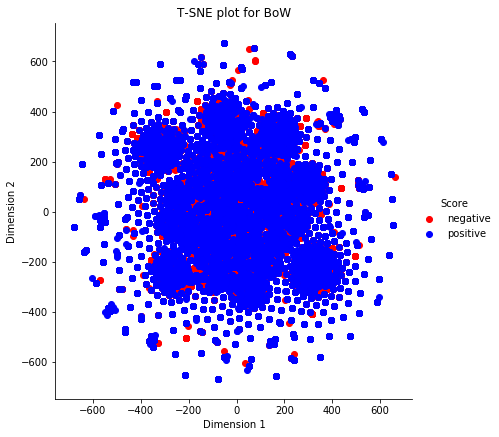

Wall time: 1h 17min 13s


In [4]:
%%time

# Generate model
bow_count_vectorizer = CountVectorizer()
model_bow = bow_count_vectorizer.fit_transform(reviews_df["CleanedText"].values)

print("the type of count vectorizer ",type(model_bow))
print("the shape of BOW vectorizer ",model_bow.get_shape())
print("the number of unique words ", model_bow.get_shape()[1])

# Data Standardization
model_bow = StandardScaler(with_mean=False).fit_transform(model_bow)

# Convert sparse matrix to dense matrix
model_bow = model_bow.todense()

# TSNE object creation with required n_iter,perplexity,learning_rate
model_bow_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_bow = model_bow_tsne.fit_transform(model_bow)

# Ploting the tsne result of BoW
plot_TSNE("T-SNE plot for BoW",create_dataframe(stack_score_to_model(tsne_bow.T)))

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of TF-IDF vectorizer  (20000, 3050)
the number of unique words  3050


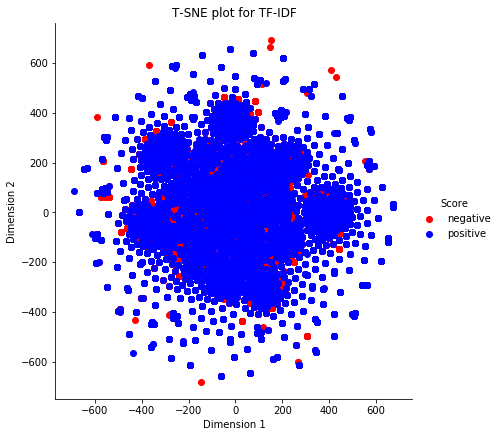

Wall time: 1h 15min 14s


In [5]:
%%time

# Generate model with perform uni-gram and bi-gram.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
model_tfidf = tfidf_vectorizer.fit_transform(reviews_df["CleanedText"].values)

print("the type of count vectorizer ",type(model_tfidf))
print("the shape of TF-IDF vectorizer ",model_tfidf.get_shape())
print("the number of unique words ", model_tfidf.get_shape()[1])

# Data Standardization
model_tfidf = StandardScaler(with_mean=False).fit_transform(model_tfidf)

# Convert sparse matrix to dense matrix
model_tfidf = model_tfidf.todense()

# TSNE object creation with required n_iter,perplexity,learning_rate
model_tfidf_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_tfidf = model_tfidf_tsne.fit_transform(model_tfidf)

# Ploting the tsne result of BoW
plot_TSNE("T-SNE plot for TF-IDF",create_dataframe(stack_score_to_model(tsne_tfidf.T)))

#### (2.3) Average Word2Vec :

number of words that occured minimum 5 times is  582


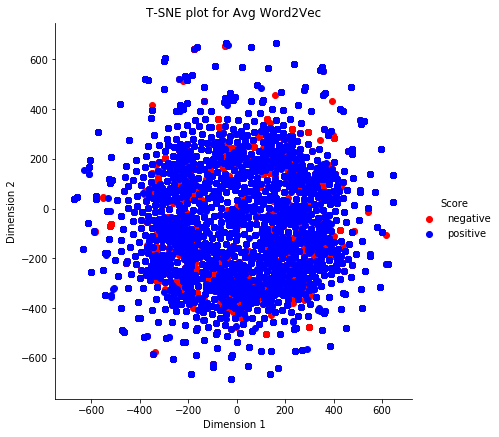

Wall time: 45min 21s


In [6]:
%%time

# Train our own Word2Vec model using text corpus

list_of_sentences=[]
for sentence in reviews_df['CleanedText'].values:
    list_of_sentences.append(sentence.split())

# Generate model.
w2v_model = Word2Vec(list_of_sentences,min_count=5,size=50, workers=6)

w2v_words =  list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times is ",len(w2v_words))

reviews = []
for sentence in list_of_sentences:
    word_2_vec = np.zeros(50)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    reviews.append(word_2_vec)

# Data Standardization
model_avg_w2v = StandardScaler().fit_transform(reviews)


# TSNE object creation with required n_iter,perplexity,learning_rate
model_avg_w2v_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_avg_w2v = model_avg_w2v_tsne.fit_transform(model_avg_w2v)

# Ploting the tsne result of BoW
plot_TSNE("T-SNE plot for Avg Word2Vec",create_dataframe(stack_score_to_model(tsne_avg_w2v.T)))

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec (TF-IDF-Word2Vec) :

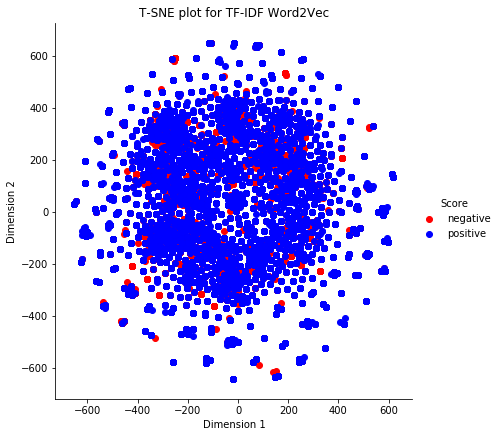

Wall time: 46min 58s


In [7]:
%%time

features = tfidf_vectorizer.get_feature_names()
reviews = []
row = 0
for sentence in list_of_sentences:
    word_2_vec = np.zeros(50)
    weight_tfidf_sum = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf_value = model_tfidf[row, features.index(word)]
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
    if weight_tfidf_sum != 0:
        word_2_vec /= tfidf_value
    reviews.append(word_2_vec)
    row += 1

# Data Standardization
model_tfidfw2v = StandardScaler().fit_transform(reviews)

# TSNE object creation with required n_iter,perplexity,learning_rate
model_tfidfw2v_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_tfidfw2v = model_tfidfw2v_tsne.fit_transform(model_tfidfw2v)

# Ploting the tsne result of BoW
plot_TSNE("T-SNE plot for TF-IDF Word2Vec",create_dataframe(stack_score_to_model(tsne_tfidfw2v.T)))

---
### Observations :
---

> 1. After applying t-SNE over BoW,TF_IDF,AVG-Word2Vec and TF_IDF-Word2Vec vectors, we conclude that, positive and negative reviews ovelap with each other.
> 2. Separating hyperplane is not possible with current technique, so different machine learing techniques are required to separate, positive and negative reviews.

